# Poppy Universe – Layer 3: Moon Neural Network Model
 
Welcome to the **Poppy Universe Layer 3 – Moon Neural Network notebook**!  
This notebook implements a **neural network-based recommendation model** using user interactions and moon parent types. This uses a **from-scratch NN implementation** without deep learning libraries.
 
> Note: This notebook currently uses **simulated user interactions** to test the Moon NN model.  
> Once we have enough real interactions, the same pipeline will process actual user data for production recommendations.
 
---
 
## Goals
 
1. **Prepare interaction data for neural network training**  
    - Encode users and moon parent types  
    - Create training dataset with one-hot encoding  
    - Split into train/validation sets
 
2. **Build and train the Neural Network from scratch**  
    - Initialize weights and biases  
    - Implement forward propagation  
    - Implement backpropagation with gradient descent  
    - Train with mini-batch updates
 
3. **Generate predictions for all user × moon_parent combinations**  
    - Create complete prediction matrix  
    - Save intermediate CSV for engine integration
 
4. **Analyze results**  
    - Visualize training loss  
    - Compare predictions with actual interactions
 
---
 
## Folder & File References
 
- **../../Input_Data/Semantic_Type_Interactions.csv** → User interaction dataset  
- **Files/Layer3_Moon_Predictions.csv** → Final predictions for engine  
- **Plots/** → Optional training curves or visualizations
 
---

## 0) Imports

In [53]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

## 1) Load Data

In [54]:
# Set random seed for reproducibility
np.random.seed(42)

# --- Load interaction dataset ---
# 'backend_df' is injected via papermill by the master notebook if backend data passed the checks
try:
    interactions = backend_df
    print("Using backend-provided interactions")
except NameError:
    # fallback to CSV if running standalone
    interactions = pd.read_csv("../../../Input_Data/NN_Semantic_Interactions.csv")
    print("Using simulated CSV interactions")

# Ensure Timestamp is datetime
interactions['Timestamp'] = pd.to_datetime(interactions['Timestamp'])

# Preview
print(f"Total interactions: {len(interactions)}")
print(f"Unique users: {interactions['User_ID'].nunique()}")
print(f"Unique categories: {interactions['Category_Type'].nunique()}")
interactions.head()

Using simulated CSV interactions
Total interactions: 12000
Unique users: 120
Unique categories: 3


,Interaction_ID,User_ID,Category_Type,Category_Value,Strength,Timestamp
0,1,50,Star,M,1,2025-11-30 02:02:11.902417
1,2,74,Star,A,5,2025-12-06 20:59:09.242640
2,3,24,Moon,Saturn,2,2025-10-26 01:39:58.938016
3,4,101,Planet,Dwarf Planet,3,2025-11-10 03:54:02.183020
4,5,110,Star,M,1,2025-11-25 05:24:18.392856


**Explanation:**  
We're loading the simulated user × type interaction data. The key columns are:
  
- `Interaction_ID`: unique identifier for each interaction  
- `User_ID`: the user who performed the interaction  
- `Category_Type`: the type of category (Star_Type, Planet_Type, Moon_Parent)  
- `Category_Value`: the specific value (e.g., "Earth" for Moon_Parent)  
- `Strength`: numerical interaction strength (1–5), our target variable  
- `Timestamp`: when the interaction occurred  

## 2) Filter Moon Parent Data

In [55]:
# Keep only rows where Category_Type is "Moon_Parent"
moon_interactions = interactions[interactions['Category_Type'] == 'Moon'].copy()

print(f"Moon interactions: {len(moon_interactions)}")
print(f"Unique users: {moon_interactions['User_ID'].nunique()}")
print(f"Unique moon parents: {moon_interactions['Category_Value'].nunique()}")
print(f"\nMoon parent values:")
print(moon_interactions['Category_Value'].value_counts())

moon_interactions.head()

Moon interactions: 2769
Unique users: 120
Unique moon parents: 10

Moon parent values:
Category_Value
Saturn      295
Pluto       292
Mars        291
Eris        284
Makemake    283
Haumea      277
Neptune     273
Uranus      269
Earth       257
Jupiter     248
Name: count, dtype: int64


,Interaction_ID,User_ID,Category_Type,Category_Value,Strength,Timestamp
2,3,24,Moon,Saturn,2,2025-10-26 01:39:58.938016
6,7,80,Moon,Mars,3,2025-10-15 04:29:29.641832
8,9,30,Moon,Saturn,2,2025-12-03 16:37:14.480889
10,11,32,Moon,Mars,4,2025-12-01 00:34:38.912650
12,13,97,Moon,Makemake,4,2025-11-09 16:59:40.702203


## 3) Encode Users and Moon Parents

In [56]:
# Encode users and moon parents as integers
user_encoder = LabelEncoder()
moon_encoder = LabelEncoder()

moon_interactions['user_encoded'] = user_encoder.fit_transform(moon_interactions['User_ID'])
moon_interactions['moon_encoded'] = moon_encoder.fit_transform(moon_interactions['Category_Value'])

# Store mappings for later use
num_users = moon_interactions['user_encoded'].nunique()
num_moons = moon_interactions['moon_encoded'].nunique()

print(f"Encoded users: {num_users}")
print(f"Encoded moon parents: {num_moons}")
print(f"Strength range: {moon_interactions['Strength'].min()} - {moon_interactions['Strength'].max()}")

moon_interactions.head()

Encoded users: 120
Encoded moon parents: 10
Strength range: 1 - 5


,Interaction_ID,User_ID,Category_Type,Category_Value,Strength,Timestamp,user_encoded,moon_encoded
2,3,24,Moon,Saturn,2,2025-10-26 01:39:58.938016,23,8
6,7,80,Moon,Mars,3,2025-10-15 04:29:29.641832,79,5
8,9,30,Moon,Saturn,2,2025-12-03 16:37:14.480889,29,8
10,11,32,Moon,Mars,4,2025-12-01 00:34:38.912650,31,5
12,13,97,Moon,Makemake,4,2025-11-09 16:59:40.702203,96,4


## 4) Prepare Training Data

In [57]:
# Extract features and target
X_user = moon_interactions['user_encoded'].values
X_moon = moon_interactions['moon_encoded'].values
y = moon_interactions['Strength'].values

# Normalize target to 0-1 range for better training
scaler = MinMaxScaler()
y_normalized = scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Split into train and validation sets
X_user_train, X_user_val, X_moon_train, X_moon_val, y_train, y_val = train_test_split(
    X_user, X_moon, y_normalized, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_user_train)}")
print(f"Validation samples: {len(X_user_val)}")

Training samples: 2215
Validation samples: 554


## 5) Neural Network Helper Functions

In [58]:
def sigmoid(z):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # clip to prevent overflow

def sigmoid_derivative(z):
    """Derivative of sigmoid function"""
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    """ReLU activation function"""
    return np.maximum(0, z)

def relu_derivative(z):
    """Derivative of ReLU function"""
    return (z > 0).astype(float)

def mse_loss(y_true, y_pred):
    """Mean squared error loss"""
    return np.mean((y_true - y_pred) ** 2)

def initialize_parameters(layer_dims):
    """
    Initialize weights and biases for all layers
    
    Args:
        layer_dims: list of layer sizes [input, hidden1, hidden2, ..., output]
    
    Returns:
        parameters: dictionary containing W1, b1, W2, b2, ...
    """
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        # He initialization for weights
        parameters[f'W{l}'] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        parameters[f'b{l}'] = np.zeros((layer_dims[l], 1))
    
    return parameters

def forward_propagation(X, parameters, activation='relu'):
    """
    Forward pass through the network
    
    Args:
        X: input features (input_size, m)
        parameters: dictionary of weights and biases
        activation: 'relu' or 'sigmoid' for hidden layers
    
    Returns:
        AL: output of the network
        caches: list of (Z, A_prev) for backprop
    """
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers
    
    # Hidden layers
    for l in range(1, L):
        A_prev = A
        Z = parameters[f'W{l}'] @ A_prev + parameters[f'b{l}']
        
        if activation == 'relu':
            A = relu(Z)
        else:
            A = sigmoid(Z)
        
        caches.append((Z, A_prev))
    
    # Output layer (sigmoid)
    A_prev = A
    Z = parameters[f'W{L}'] @ A_prev + parameters[f'b{L}']
    AL = sigmoid(Z)
    caches.append((Z, A_prev))
    
    return AL, caches

def backward_propagation(AL, Y, caches, parameters, activation='relu'):
    """
    Backward pass through the network
    
    Args:
        AL: output of forward prop
        Y: true labels
        caches: list of (Z, A_prev) from forward prop
        parameters: current weights and biases
        activation: 'relu' or 'sigmoid' for hidden layers
    
    Returns:
        grads: dictionary of gradients
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    
    # Output layer gradient
    dZ = AL - Y
    grads[f'dW{L}'] = (1/m) * dZ @ caches[L-1][1].T
    grads[f'db{L}'] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    
    # Hidden layers
    for l in reversed(range(1, L)):
        Z, A_prev = caches[l-1]
        dA = parameters[f'W{l+1}'].T @ dZ
        
        if activation == 'relu':
            dZ = dA * relu_derivative(Z)
        else:
            dZ = dA * sigmoid_derivative(Z)
        
        grads[f'dW{l}'] = (1/m) * dZ @ A_prev.T
        grads[f'db{l}'] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    
    return grads

def update_parameters(parameters, grads, learning_rate):
    """Update parameters using gradient descent"""
    L = len(parameters) // 2
    
    for l in range(1, L + 1):
        parameters[f'W{l}'] -= learning_rate * grads[f'dW{l}']
        parameters[f'b{l}'] -= learning_rate * grads[f'db{l}']
    
    return parameters

## 6) Prepare Input Features (One-Hot Encoding)

In [59]:
def create_one_hot(indices, num_classes):
    """Create one-hot encoded matrix"""
    one_hot = np.zeros((num_classes, len(indices)))
    one_hot[indices, np.arange(len(indices))] = 1
    return one_hot

# Create one-hot encoded features
X_train_user_onehot = create_one_hot(X_user_train, num_users)
X_train_moon_onehot = create_one_hot(X_moon_train, num_moons)
X_train = np.vstack([X_train_user_onehot, X_train_moon_onehot])

X_val_user_onehot = create_one_hot(X_user_val, num_users)
X_val_moon_onehot = create_one_hot(X_moon_val, num_moons)
X_val = np.vstack([X_val_user_onehot, X_val_moon_onehot])

# Reshape y
Y_train = y_train.reshape(1, -1)
Y_val = y_val.reshape(1, -1)

print(f"Training input shape: {X_train.shape}")
print(f"Training output shape: {Y_train.shape}")
print(f"Validation input shape: {X_val.shape}")
print(f"Validation output shape: {Y_val.shape}")


Training input shape: (130, 2215)
Training output shape: (1, 2215)
Validation input shape: (130, 554)
Validation output shape: (1, 554)


## 7) Train Neural Network

In [60]:
# Network architecture
input_size = num_users + num_moons
hidden_layers = [64, 32, 16]
output_size = 1
layer_dims = [input_size] + hidden_layers + [output_size]

print(f"Network architecture: {layer_dims}")

# Initialize parameters
parameters = initialize_parameters(layer_dims)

# Training hyperparameters
learning_rate = 0.01
num_epochs = 1000
print_every = 100

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Forward propagation
    AL_train, caches = forward_propagation(X_train, parameters, activation='relu')
    
    # Compute training loss
    train_loss = mse_loss(Y_train, AL_train)
    train_losses.append(train_loss)
    
    # Backward propagation
    grads = backward_propagation(AL_train, Y_train, caches, parameters, activation='relu')
    
    # Update parameters
    parameters = update_parameters(parameters, grads, learning_rate)
    
    # Validation loss
    AL_val, _ = forward_propagation(X_val, parameters, activation='relu')
    val_loss = mse_loss(Y_val, AL_val)
    val_losses.append(val_loss)
    
    # Print progress
    if (epoch + 1) % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

print("\nTraining complete!")

Network architecture: [130, 64, 32, 16, 1]
Epoch 100/1000 - Train Loss: 0.106699, Val Loss: 0.110420
Epoch 200/1000 - Train Loss: 0.103705, Val Loss: 0.106377
Epoch 300/1000 - Train Loss: 0.102385, Val Loss: 0.104311
Epoch 400/1000 - Train Loss: 0.101736, Val Loss: 0.103161
Epoch 500/1000 - Train Loss: 0.101425, Val Loss: 0.102527
Epoch 600/1000 - Train Loss: 0.101262, Val Loss: 0.102167
Epoch 700/1000 - Train Loss: 0.101163, Val Loss: 0.101948
Epoch 800/1000 - Train Loss: 0.101092, Val Loss: 0.101808
Epoch 900/1000 - Train Loss: 0.101034, Val Loss: 0.101720
Epoch 1000/1000 - Train Loss: 0.100983, Val Loss: 0.101658

Training complete!


## 8) Visualize Training

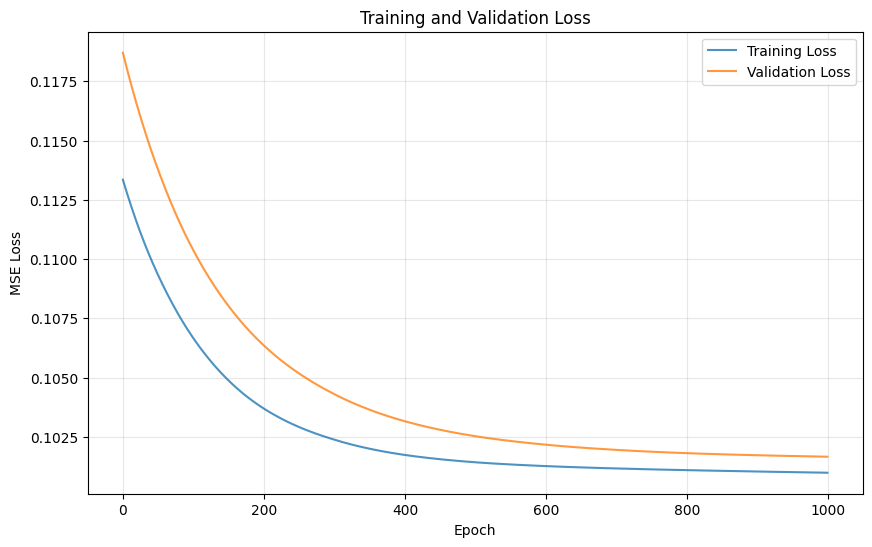

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../Plots/L4_moon_nn_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

## 9) Generate Full Prediction Matrix

In [62]:
# Create all possible user × moon combinations
all_users = np.arange(num_users)
all_moons = np.arange(num_moons)

# Create meshgrid
user_grid, moon_grid = np.meshgrid(all_users, all_moons, indexing='ij')
user_flat = user_grid.flatten()
moon_flat = moon_grid.flatten()

# One-hot encode
X_all_user_onehot = create_one_hot(user_flat, num_users)
X_all_moon_onehot = create_one_hot(moon_flat, num_moons)
X_all = np.vstack([X_all_user_onehot, X_all_moon_onehot])

# Generate predictions
predictions_normalized, _ = forward_propagation(X_all, parameters, activation='relu')

# Denormalize predictions back to original scale
predictions = scaler.inverse_transform(predictions_normalized.T).flatten()

# Clip to valid range [1, 5]
predictions = np.clip(predictions, 1, 5)

print(f"Generated {len(predictions)} predictions")
print(f"Prediction range: {predictions.min():.2f} - {predictions.max():.2f}")

Generated 1200 predictions
Prediction range: 3.15 - 3.57


## 10) Convert to DataFrame

In [63]:
# Reshape predictions into matrix
prediction_matrix = predictions.reshape(num_users, num_moons)

# Decode user and moon IDs
user_ids = user_encoder.inverse_transform(all_users)
moon_values = moon_encoder.inverse_transform(all_moons)

# Create DataFrame
R_hat_df = pd.DataFrame(prediction_matrix, columns=moon_values)
R_hat_df.insert(0, 'User_ID', user_ids)

print(R_hat_df.head())

   User_ID     Earth      Eris    Haumea   Jupiter  Makemake      Mars  \
0        1  3.317729  3.372776  3.301848  3.349454  3.409667  3.453566   
1        2  3.274866  3.352686  3.304060  3.310119  3.285074  3.371296   
2        3  3.376596  3.424115  3.331473  3.386874  3.432201  3.545526   
3        4  3.374441  3.431683  3.326288  3.393182  3.466983  3.485592   
4        5  3.339856  3.320063  3.302998  3.329571  3.376201  3.379391   

    Neptune     Pluto    Saturn    Uranus  
0  3.368578  3.497113  3.345401  3.263951  
1  3.296369  3.354462  3.368783  3.227476  
2  3.417788  3.448155  3.449126  3.322976  
3  3.423131  3.472643  3.438282  3.402168  
4  3.368089  3.364556  3.426510  3.338830  


## 11) Save Predictions to CSV

In [64]:
# Ensure output directory exists
#os.makedirs('../Files', exist_ok=True)

# Save as CSV for master notebook
R_hat_df.to_csv('../Files/Layer4_Moon_Predictions.csv', index=False)

print("Predictions saved to ../Files/Layer4_Moon_Predictions.csv")
print(f"Shape: {R_hat_df.shape}")

Predictions saved to ../Files/Layer4_Moon_Predictions.csv
Shape: (120, 11)


## 12) Analyze Predictions

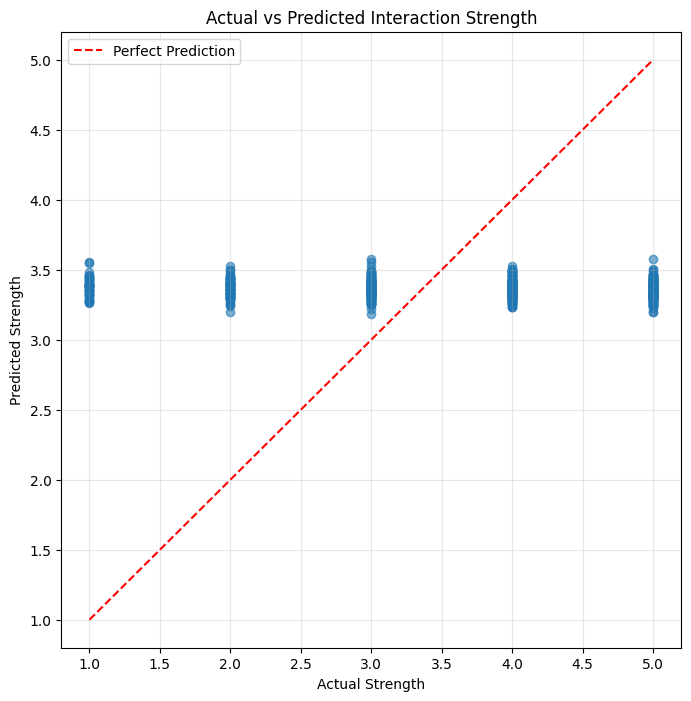

Validation MAE: 1.0965
Validation RMSE: 1.2754


In [65]:
# Compare actual vs predicted for validation set
AL_val_pred, _ = forward_propagation(X_val, parameters, activation='relu')
y_val_pred = scaler.inverse_transform(AL_val_pred.T).flatten()
y_val_actual = scaler.inverse_transform(Y_val.T).flatten()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_val_actual, y_val_pred, alpha=0.6)
plt.plot([1, 5], [1, 5], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Strength')
plt.ylabel('Predicted Strength')
plt.title('Actual vs Predicted Interaction Strength')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../Plots/L4_moon_nn_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

# Compute metrics
mae = np.mean(np.abs(y_val_actual - y_val_pred))
rmse = np.sqrt(np.mean((y_val_actual - y_val_pred) ** 2))

print(f"Validation MAE: {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

## Summary
 
This notebook successfully:
1. ✅ Loaded and filtered moon parent interactions
2. ✅ Implemented a neural network from scratch (no deep learning libraries)
3. ✅ Trained the model using forward/backward propagation
4. ✅ Generated predictions for all user × moon combinations
5. ✅ Saved the prediction matrix for engine consumption
 
The predictions are now ready to be used in the recommendation engine!